In [1]:
import pandas as pd
import pathlib as Path
import matplotlib.pyplot as plt

In [2]:
# Setting up the Dataframe
file_path = "https://raw.githubusercontent.com/ComfyKoala/diabetes-classification/main/JV/Resources/diabetes_dataset.csv"

dm_pd = pd.read_csv(file_path)

dm_pd.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [3]:
new_column_names = {
    'hbA1c_level': 'A1C',
    'blood_glucose_level': 'RBG',
    'hypertension': 'HTN',
    'race:AfricanAmerican': 'AfricanAmerican',
    'race:Asian': 'Asian',
    'race:Caucasian': 'Caucasian',
    'race:Hispanic': 'Hispanic',
    'race:Other': 'Other'
}

# Rename the columns in the DataFrame
dm_pd.rename(columns=new_column_names, inplace=True)

In [4]:
# Viewing the size and columns of the Dataframe
print(dm_pd.shape)
print(dm_pd.columns)

(100000, 16)
Index(['year', 'gender', 'age', 'location', 'AfricanAmerican', 'Asian',
       'Caucasian', 'Hispanic', 'Other', 'HTN', 'heart_disease',
       'smoking_history', 'bmi', 'A1C', 'RBG', 'diabetes'],
      dtype='object')


In [5]:
# Obtaining summary statistics for the non-Boolean columns
dm_pd[['bmi','A1C','RBG']].describe()

,bmi,A1C,RBG
count,100000.000000,100000.000000,100000.000000
mean,27.320767,5.527507,138.058060
std,6.636783,1.070672,40.708136
min,10.010000,3.500000,80.000000
25%,23.630000,4.800000,100.000000
50%,27.320000,5.800000,140.000000
75%,29.580000,6.200000,159.000000
max,95.690000,9.000000,300.000000


In [6]:
# Getting counts of how many do not have DM (0) vs. how many have DM (1)
dm_pd['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

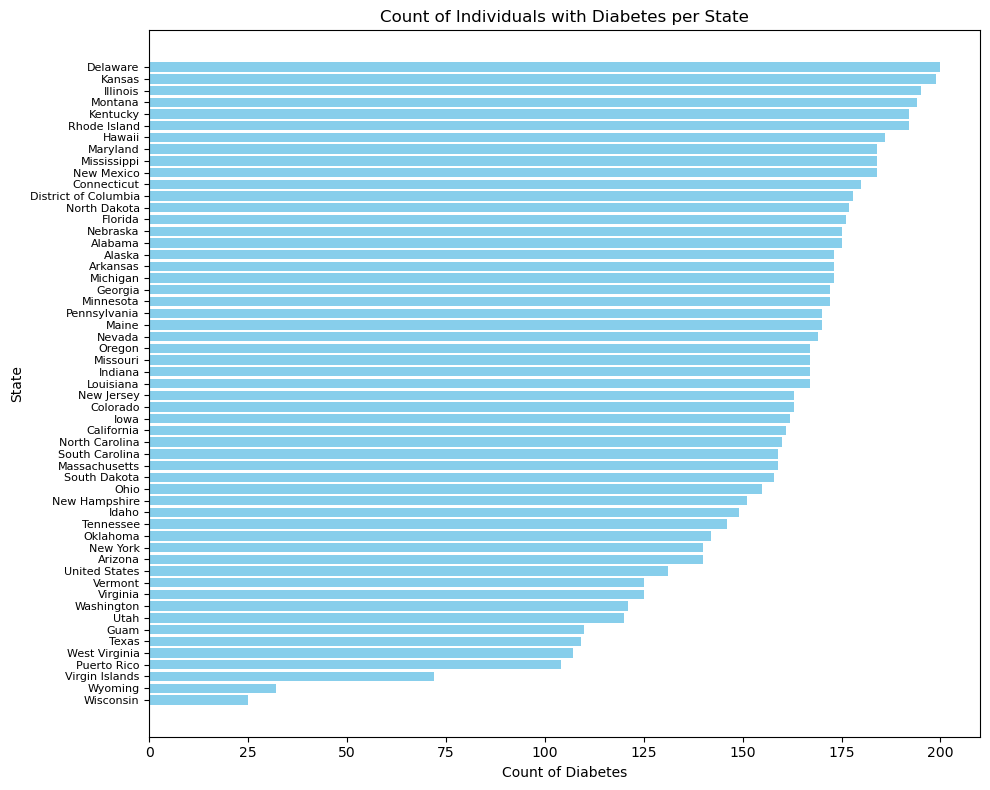

In [24]:
# Filter the DataFrame to include only rows where 'diabetes' is equal to 1
filtered_df = dm_pd[dm_pd['diabetes'] == 1]

# Group the filtered DataFrame by the 'location' column and count the occurrences of 'diabetes' for each state
grouped_data = filtered_df.groupby('location').size().reset_index(name='count')

# Sort the grouped data by the count of diabetes in ascending order
grouped_data = grouped_data.sort_values(by='count', ascending=True)

# Create a horizontal bar graph with increased spacing between bars
plt.figure(figsize=(10, 8))
bar_width = 0.8
bar_positions = range(len(grouped_data['location']))
plt.barh(bar_positions, grouped_data['count'], height=bar_width, color='skyblue')
plt.yticks(bar_positions, grouped_data['location'], fontsize=8)  # Set y-ticks to display state names
plt.xlabel('Count of Diabetes')
plt.ylabel('State')
plt.title('Count of Individuals with Diabetes per State')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [14]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np

# Prepping data for nn Model

In [15]:
dm_pd.head()

,year,gender,age,location,AfricanAmerican,Asian,Caucasian,Hispanic,Other,HTN,heart_disease,smoking_history,bmi,A1C,RBG,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [16]:
dm_pd_dropped = dm_pd.drop(columns=['location', 'smoking_history'])
dm_pd_dropped['bmi'].value_counts()

,count
bmi,
27.32,25495
23.00,103
27.12,101
24.96,100
27.80,100
...,...
67.54,1
59.96,1
12.29,1


In [18]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
cutoff_value = 10
counts = dm_pd_dropped['bmi'].value_counts()
classifications_to_replace = counts[counts < cutoff_value].index.tolist()


# Replace in dataframe
for cls in classifications_to_replace:
    dm_pd_dropped['bmi'] = dm_pd_dropped['bmi'].replace(cls,"Other")

# Check to make sure replacement was successful
dm_pd_dropped['bmi'].value_counts()

,count
bmi,
27.32,25495
Other,6327
23.0,103
27.12,101
24.96,100
...,...
37.37,10
30.17,10
41.36,10


In [29]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_columns = dm_pd.select_dtypes(include=['object']).columns

dm_df_encoded = pd.get_dummies(dm_pd, columns=categorical_columns)

dm_df_encoded.head()

,year,age,AfricanAmerican,Asian,Caucasian,Hispanic,Other,HTN,heart_disease,bmi,...,location_Washington,location_West Virginia,location_Wisconsin,location_Wyoming,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,2020,32.0,0,0,0,0,1,0,0,27.32,...,False,False,False,False,False,False,False,False,True,False
1,2015,29.0,0,1,0,0,0,0,0,19.95,...,False,False,False,False,False,False,False,False,True,False
2,2015,18.0,0,0,0,0,1,0,0,23.76,...,False,False,False,False,False,False,False,False,True,False
3,2015,41.0,0,0,1,0,0,0,0,27.32,...,False,False,False,False,False,False,False,False,True,False
4,2016,52.0,1,0,0,0,0,0,0,23.75,...,False,False,False,False,False,False,False,False,True,False


In [30]:
# Split our preprocessed data into our features and target arrays
X = dm_df_encoded.drop('diabetes', axis=1)
y = dm_df_encoded['diabetes']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Running Optimization using keras-tuner

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=2355))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [ ]:
# Import the kerastuner library
!pip install keras-tuner
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

# Overall Result of kerastuner, to save time:

# Trial 56 Complete [00h 03m 11s]
# val_accuracy: 0.953719973564148

# Best val_accuracy So Far: 0.9545999765396118
# Total elapsed time: 01h 08m 44s

Trial 56 Complete [00h 03m 11s]
val_accuracy: 0.953719973564148

Best val_accuracy So Far: 0.9545999765396118
Total elapsed time: 01h 08m 44s


In [ ]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values


# Best Hyperparameters to save time:

# {'activation': 'sigmoid',
#  'first_units': 9,
#  'num_layers': 3,
#  'units_0': 9,
#  'units_1': 3,
#  'units_2': 5,
#  'units_3': 9,
#  'units_4': 1,
#  'units_5': 1,
#  'tuner/epochs': 7,
#  'tuner/initial_epoch': 3,
#  'tuner/bracket': 2,
#  'tuner/round': 1,
#  'tuner/trial_id': '0032'}

{'activation': 'sigmoid',
 'first_units': 9,
 'num_layers': 3,
 'units_0': 9,
 'units_1': 3,
 'units_2': 5,
 'units_3': 9,
 'units_4': 1,
 'units_5': 1,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0032'}

In [ ]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam

782/782 - 1s - 2ms/step - accuracy: 0.9546 - loss: 0.1432
Loss: 0.1432427167892456, Accuracy: 0.9545999765396118


# Compile, Train and Evaluate nn Model based on optimization

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = 76
layer1 = 9
layer2 = 3
layer3 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=layer1, input_dim=number_input_features, activation='relu')
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=layer2, activation='sigmoid'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=layer2, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 9)                   │             693 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739 (2.89 KB)

 Trainable params: 739 (2.89 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9123 - loss: 0.3798
Epoch 2/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9245 - loss: 0.1694
Epoch 3/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9587 - loss: 0.1346
Epoch 4/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9598 - loss: 0.1207
Epoch 5/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9604 - loss: 0.1185
Epoch 6/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9610 - loss: 0.1128
Epoch 7/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9620 - loss: 0.1103
Epoch 8/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9597 - loss: 0.1130
Epoch 9/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9601 - loss: 0.1119
Epoch 10/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9594 - loss: 0.1129
Epoch 11/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9606 - loss: 0.1104
Epoch 12/100
2344/

In [35]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

782/782 - 1s - 1ms/step - accuracy: 0.9702 - loss: 0.0892
Loss: 0.0891822949051857, Accuracy: 0.9702399969100952


In [ ]:
#Generate training predictions
training_predictions = nn.predict(X_train)

#Generate testing predictions
testing_predictions = nn.predict(X_test)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [37]:
# !pip install scikeras scikit-learn
# !pip install --upgrade scipy scikit-learn scikeras

from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance
import numpy as np

# Ensure that nn is defined as your Keras model

# Define the wrapped model (assuming nn is your Keras Sequential model)
wrapped_nn = KerasClassifier(model=nn, epochs=10, batch_size=32, verbose=0)

# Train the wrapped model
wrapped_nn.fit(X_train_scaled, y_train)

# Compute permutation importance
result = permutation_importance(wrapped_nn, X_test_scaled, y_test, n_repeats=5, random_state=5)

# Get feature importances
importances = result.importances_mean

# Ensure X_test_scaled is a DataFrame or convert it
if not isinstance(X_test_scaled, pd.DataFrame):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Sort the features by importance in ascending order (weakest to strongest)
sorted_indices = np.argsort(importances)

# Get the top 20 weakest features
top_20_weakest_indices = sorted_indices[:20]
top_20_weakest_features = X_test_scaled.columns[top_20_weakest_indices]
top_20_weakest_importances = importances[top_20_weakest_indices]

# Display the weakest features and their importances
for feature, importance in zip(top_20_weakest_features, top_20_weakest_importances):
    print(f"Weakest feature: {feature} with importance {importance}")

Weakest feature: HTN with importance -4.0000000000040004e-05
Weakest feature: gender_Other with importance 1.5999999999971593e-05
Weakest feature: heart_disease with importance 3.999999999995119e-05
Weakest feature: location_Wisconsin with importance 0.00010399999999997079
Weakest feature: year with importance 0.0001279999999999726
Weakest feature: bmi with importance 0.00018399999999996197
Weakest feature: location_Wyoming with importance 0.00019199999999999217
Weakest feature: location_Guam with importance 0.0006719999999999615
Weakest feature: location_Virginia with importance 0.0007119999999999794
Weakest feature: gender_Male with importance 0.0007199999999999874
Weakest feature: location_Virgin Islands with importance 0.0007599999999999829
Weakest feature: location_Vermont with importance 0.0008159999999999723
Weakest feature: age with importance 0.0008479999999999821
Weakest feature: location_West Virginia with importance 0.0008559999999999679
Weakest feature: location_Puerto Ric

In [38]:
# # Define the wrapped model (assuming nn is your Keras Sequential model)
# wrapped_nn = KerasClassifier(model=nn, epochs=20, batch_size=32, verbose=0)

# # Train the wrapped model
# wrapped_nn.fit(X_train_scaled, y_train)

# # Compute permutation importance
# result = permutation_importance(wrapped_nn, X_test_scaled, y_test, n_repeats=10, random_state=10)

# Get feature importances
importances = result.importances_mean

# Ensure X_test_scaled is a DataFrame or convert it
if not isinstance(X_test_scaled, pd.DataFrame):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Sort the features by importance in descending order (strongest to weakest)
sorted_indices = np.argsort(importances)[::-1]

# Get the top 20 strongest features
top_20_strongest_indices = sorted_indices[:20]
top_20_strongest_features = X_test_scaled.columns[top_20_strongest_indices]
top_20_strongest_importances = importances[top_20_strongest_indices]

# Display the strongest features and their importances
for feature, importance in zip(top_20_strongest_features, top_20_strongest_importances):
    print(f"Strongest feature: {feature} with importance {importance}")

Strongest feature: A1C with importance 0.06193599999999995
Strongest feature: RBG with importance 0.03690399999999996
Strongest feature: smoking_history_never with importance 0.008863999999999983
Strongest feature: smoking_history_No Info with importance 0.008127999999999958
Strongest feature: smoking_history_former with importance 0.004063999999999979
Strongest feature: smoking_history_current with importance 0.0030479999999999618
Strongest feature: AfricanAmerican with importance 0.0024079999999999657
Strongest feature: Hispanic with importance 0.0022959999999999647
Strongest feature: Asian with importance 0.0021360000000000046
Strongest feature: Other with importance 0.0020079999999999655
Strongest feature: smoking_history_not current with importance 0.0018799999999999707
Strongest feature: Caucasian with importance 0.0018719999999999848
Strongest feature: smoking_history_ever with importance 0.0017519999999999313
Strongest feature: location_Hawaii with importance 0.0015679999999999